# **Trabalho 5 - Reconhecimento de Padrões**
#### Renan Henrique Cardoso - 379013

In [1]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt

## Regressão Linear Múltipla


#### kc_house_data.csv

In [2]:
kc_house = pd.read_csv("https://raw.githubusercontent.com/cardosorrenan/reconhecimentopadroes-ufc/master/datasets/kc_house_data.csv")
kc_house = kc_house.sample(frac=1)         
kc_house = kc_house.reset_index(drop=True)
house = kc_house.drop(['id', 'date'], axis=1)

#### Rotulação dos sinais (delimitação dos folds)

In [3]:
n_fold = 5
house['fold'] = pd.DataFrame(data=[-1]*house.shape[0])  # Todas as linhas da coluna 'fold' recebe -1, pois ainda não pertencem a nenhum fold
samples = math.floor(house.shape[0] / n_fold)           # Quantidade de amostras em cada fold
for fold in list(range(0, n_fold)):                     # Como K=10, cada linha pertencerá a um fold [0, 1, ..., 9] 
  base = fold*samples
  top = fold*samples + samples - 1
  house.loc[base:top, 'fold'] = fold                    # 0-4321 será 0-Fold / 4322-8643 será 1-Fold / ... / 17288-21609 será 4-Fold
house = house.query('fold != -1')                       # Perda de 3 amostras

#### Funções construídas

In [4]:
def split_house(house):
  # Dados de treinamento
  train = house.query(f'fold != {validation}')  
  train = train.drop(['fold'], axis=1).reset_index(drop=True)
  ones = pd.DataFrame(data=np.ones((train.shape[0], 1)), columns=['ones'])
  train_x = pd.concat([ones, train.drop(['price'], axis=1)], axis=1)
  train_y = train['price']
  train_x = train_x.to_numpy()
  train_y = train_y.to_numpy()
  # Dados de teste
  test = house.query(f'fold == {validation}')   
  test = test.drop(['fold'], axis=1).reset_index(drop=True)
  ones = pd.DataFrame(data=np.ones((test.shape[0], 1)), columns=['ones'])
  test_x = pd.concat([ones, test.drop(['price'], axis=1)], axis=1)
  test_y = test['price']
  test_x = test_x.to_numpy()
  test_y = test_y.to_numpy()
  return train_x, train_y, test_x, test_y


def get_r2adj(y, y_estimated):
  rss = 0
  tss = 0
  y_mean = np.mean(y)
  for i, item in enumerate(y):
    rss += (item - y_estimated[i])**2
    tss += (item - y_mean)**2
  k = 1
  p = k + 1
  rss = rss/(y.shape[0] - p)
  tss = tss/(y_estimated.shape[0] - 1)
  r2_adj = 1-(rss/tss)
  r2_adj = round(r2_adj, 7)
  return r2_adj

#### Loop principal

In [5]:
results = pd.DataFrame()

for validation in list(range(0, n_fold)):
  train_x, train_y, test_x, test_y = split_house(house)
  beta = np.linalg.inv((train_x.T @ train_x) + np.identity((train_x.T @ train_x).shape[0]) * 0.01) @ train_x.T @ train_y
  y_estimated = test_x @ beta
  r2_adj = get_r2adj(test_y, y_estimated)
  results = pd.concat([results, pd.Series(y_estimated, name=f'{r2_adj}')], axis=1)
  print(f'Fold {validation}: {round(r2_adj, 4)}')

best_r2 = sorted(results.columns.to_list())[-1]
best_y = results[best_r2].to_numpy()
print(f'\nBest: {results.columns.get_loc(best_r2)}º - {best_r2}')

Fold 0: 0.7085
Fold 1: 0.6842
Fold 2: 0.6909
Fold 3: 0.7056
Fold 4: 0.6994

Best: 0º - 0.7084691


**O modelo estimado de regressão (linear) “se ajustou” bem aos dados? Justifique.**

Apesar do coeficiente de determinação r2 ajustado não apresentar valores expressivos, foi observado que o modelo com melhor resultado conseguiu acompanhar as variações como nesse exemplo abaixo, onde foi realizada a captura de 70 amostras para comparar graficamente os valores reais e preditos pela regressão.

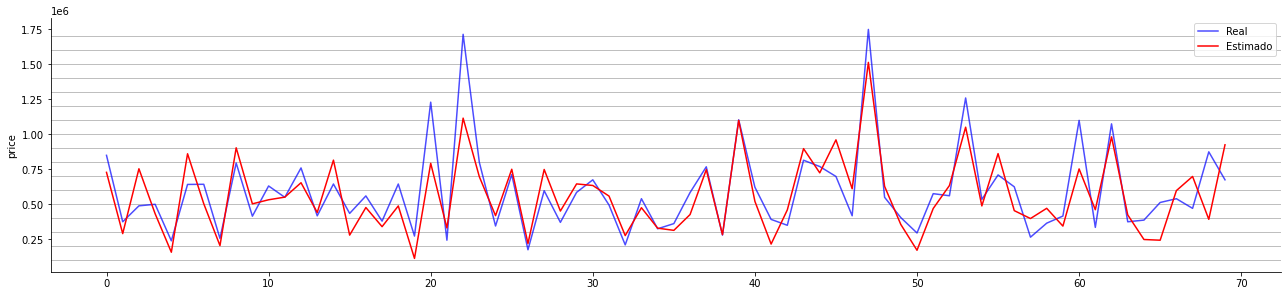

In [6]:
sample_real = house.query(f'fold == {results.columns.get_loc(best_r2)}')['price'][0:70]
sample_estimated = best_y[0:70]
values = np.sort(np.concatenate((sample_real.values, sample_estimated)))
floor = int(round(values[0]/100000, 0))
ceil = int(round(values[-1]/100000, 0))
chart = sns.relplot()
for i in range(floor, ceil):
  chart.axes[0][0].axhline(y=i*100000, color='black', linewidth=1, alpha=0.25)
sns.lineplot(x=list(range(sample_real.shape[0])), y=sample_real, color='b', alpha=0.7, label="Real")
sns.lineplot(x=list(range(sample_estimated.shape[0])), y=sample_estimated, color='r', label="Estimado")
plt.gcf().set_size_inches(20, 4)



---



## Regressão Polinomial


#### Aerogerador.dat

In [8]:
aero = pd.read_csv("https://github.com/cardosorrenan/reconhecimentopadroes-ufc/raw/master/datasets/aerogerador.dat", sep='\t').drop(['Unnamed: 2'], axis=1)
aero.columns = ['wind', 'power']
aero = aero.sample(frac=1)         
aero = aero.reset_index(drop=True)

#### Funções construídas

In [9]:
def split_aero(aero, d):
  train_x, train_y, test_x, test_y = [], [], [], []
  cut = round(aero.shape[0]*0.7)
  train = aero.iloc[0:cut].reset_index(drop=True)
  test = aero.iloc[cut:-1].reset_index(drop=True)
  train_x = prepare_input(train['wind'], d)
  train_y = train['power'].to_numpy()
  test_x = prepare_input(test['wind'], d)
  test_y = test['power'].to_numpy()
  return train_x, train_y, test_x, test_y


def prepare_input(x, d):
  ones = pd.Series(data=np.ones(x.shape[0]))
  X = pd.Series(ones)
  for i in range(0, d):
    X = pd.concat([X, x**(i+1)], axis=1)
  X = X.to_numpy()
  return X


def get_output(x, beta):
  y_final = 0
  for i, item in enumerate(x.T):
    y_final += beta[i]*item
  return y_final

#### Loop principal

1º: 0.9312852
2º: 0.9462877
3º: 0.9730051
4º: 0.9780416
5º: 0.9780328

Best: 4º - 0.9780416


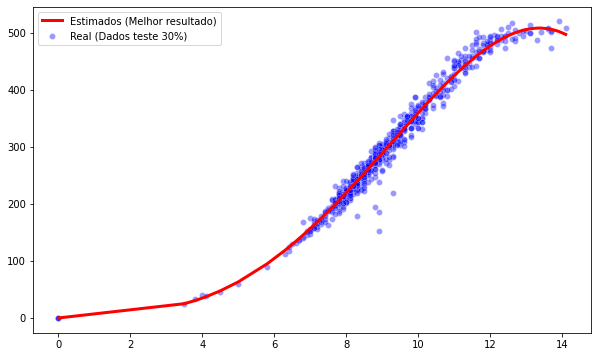

In [10]:
results = pd.DataFrame()

for degree in range(1, 6):
  train_x, train_y, test_x, test_y = split_aero(aero, degree)
  beta = np.linalg.inv((train_x.T @ train_x) + np.identity((train_x.T @ train_x).shape[0]) * 0.01) @ train_x.T @ train_y
  y_estimated = get_output(test_x, beta)
  r2_adj = get_r2adj(test_y, y_estimated)
  results = pd.concat([results, pd.Series(y_estimated, name=f'{r2_adj}')], axis=1)
  print(f'{degree}º: {r2_adj}')

best_r2 = sorted(results.columns.to_list())[-1]
best_y = results[best_r2].to_numpy()
print(f'\nBest: {results.columns.get_loc(best_r2) + 1}º - {best_r2}')

sns.scatterplot(x=test_x[:,1], y=test_y, color='b', alpha=0.4, label="Real (Dados teste 30%)")
sns.lineplot(x=test_x[:,1], y=best_y, color='r', linewidth=3, label="Estimados (Melhor resultado)")
plt.gcf().set_size_inches(10, 6)

**Qual seria o melhor valor de k para a aproximação desta curva de geração de potência? Justifique.**

A partir de k=3 não é observado nenhuma melhora expressiva no resultado final do modelo, isso ocorre devido ao fato de que quando aumentamos o grau do polinômio, o número de variáveis cresce de forma exponencial, sendo assim, a variância do modelo se torna muito alta e resulta rapidamente num aprendizado impraticável.

(Melhor k=5)